In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import os

# Define dataset directory
dataset_dir = r"D:\Pattern_Recognition\realwaste\realwaste-main\RealWaste"

image_size = (524, 524)  
batch_size = 32
seed = 123

# Load the dataset
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)


Found 4752 files belonging to 9 classes.


In [5]:

# Get the total number of samples
num_samples = len(full_dataset.file_paths)


# Calculate the split sizes
train_size = int(0.6 * num_samples/32)
val_size = int(0.2 * num_samples/32)
test_size = int(num_samples/32 - train_size - val_size)  


print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Split the dataset
train_dataset = full_dataset.take(train_size)
remainder_dataset = full_dataset.skip(train_size)

val_dataset = remainder_dataset.take(val_size)
test_dataset = remainder_dataset.skip(val_size)

# Normalize pixel values 
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize data loading
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")


Total samples: 4752
Training samples: 89
Validation samples: 29
Test samples: 30
Total samples: 4752
Training samples: 89
Validation samples: 29
Test samples: 30


In [6]:
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet


# Load InceptionResNetV2 pre-trained on ImageNet
InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(524, 524, 3))

# Freeze the layers of InceptionResNetV2
for layer in InceptionResNetV2.layers:
    layer.trainable = False

InceptionResNetV2_out = layers.GlobalAveragePooling2D()(InceptionResNetV2.output)
InceptionResNetV2_out = layers.Dense(128, activation='relu')(InceptionResNetV2_out)
InceptionResNetV2_out = layers.Dense(9, activation='softmax')(InceptionResNetV2_out)

InceptionResNetV2 = models.Model(inputs=InceptionResNetV2.input, outputs=InceptionResNetV2_out)

# Load DenseNet121 pre-trained on ImageNet
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(524, 524, 3))

# Freeze layers of DenseNet
for layer in densenet_model.layers:
    layer.trainable = False

densenet_model_out = layers.GlobalAveragePooling2D()(densenet_model.output)
densenet_model_out = layers.Dense(128, activation='relu')(densenet_model_out)
densenet_model_out = layers.Dense(9, activation='softmax')(densenet_model_out)

densenet_model = models.Model(inputs=densenet_model.input, outputs=densenet_model_out)


In [7]:
# Compile your model 
InceptionResNetV2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_InceptionResNetV2 = InceptionResNetV2.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=2)


Epoch 1/10
89/89 - 107s - loss: 1.1167 - accuracy: 0.6419 - val_loss: 0.8044 - val_accuracy: 0.7414 - 107s/epoch - 1s/step
Epoch 2/10
89/89 - 76s - loss: 0.6208 - accuracy: 0.7893 - val_loss: 0.6734 - val_accuracy: 0.7748 - 76s/epoch - 858ms/step
Epoch 3/10
89/89 - 76s - loss: 0.5265 - accuracy: 0.8255 - val_loss: 0.5351 - val_accuracy: 0.8136 - 76s/epoch - 850ms/step
Epoch 4/10
89/89 - 75s - loss: 0.4605 - accuracy: 0.8487 - val_loss: 0.5342 - val_accuracy: 0.8136 - 75s/epoch - 845ms/step
Epoch 5/10
89/89 - 75s - loss: 0.4006 - accuracy: 0.8662 - val_loss: 0.5086 - val_accuracy: 0.8308 - 75s/epoch - 846ms/step
Epoch 6/10
89/89 - 77s - loss: 0.3485 - accuracy: 0.8894 - val_loss: 0.4232 - val_accuracy: 0.8416 - 77s/epoch - 863ms/step
Epoch 7/10
89/89 - 76s - loss: 0.3019 - accuracy: 0.9059 - val_loss: 0.4574 - val_accuracy: 0.8405 - 76s/epoch - 853ms/step
Epoch 8/10
89/89 - 75s - loss: 0.2873 - accuracy: 0.9073 - val_loss: 0.4073 - val_accuracy: 0.8675 - 75s/epoch - 846ms/step
Epoch 9/1

In [8]:
# Compile the DenseNet-based model
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_densenet = densenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
89/89 [==============================] - 47s 466ms/step - loss: 1.2129 - accuracy: 0.6032 - val_loss: 0.8549 - val_accuracy: 0.7134
Epoch 2/10
89/89 [==============================] - 40s 452ms/step - loss: 0.6851 - accuracy: 0.7647 - val_loss: 0.6450 - val_accuracy: 0.7909
Epoch 3/10
89/89 [==============================] - 40s 451ms/step - loss: 0.5374 - accuracy: 0.8199 - val_loss: 0.5392 - val_accuracy: 0.8330
Epoch 4/10
89/89 [==============================] - 40s 452ms/step - loss: 0.4489 - accuracy: 0.8501 - val_loss: 0.6065 - val_accuracy: 0.7866
Epoch 5/10
89/89 [==============================] - 40s 450ms/step - loss: 0.3962 - accuracy: 0.8683 - val_loss: 0.4661 - val_accuracy: 0.8308
Epoch 6/10
89/89 [==============================] - 40s 452ms/step - loss: 0.3595 - accuracy: 0.8810 - val_loss: 0.4644 - val_accuracy: 0.8308
Epoch 7/10
89/89 [==============================] - 40s 452ms/step - loss: 0.3245 - accuracy: 0.8880 - val_loss: 0.4503 - val_accuracy: 0.8319

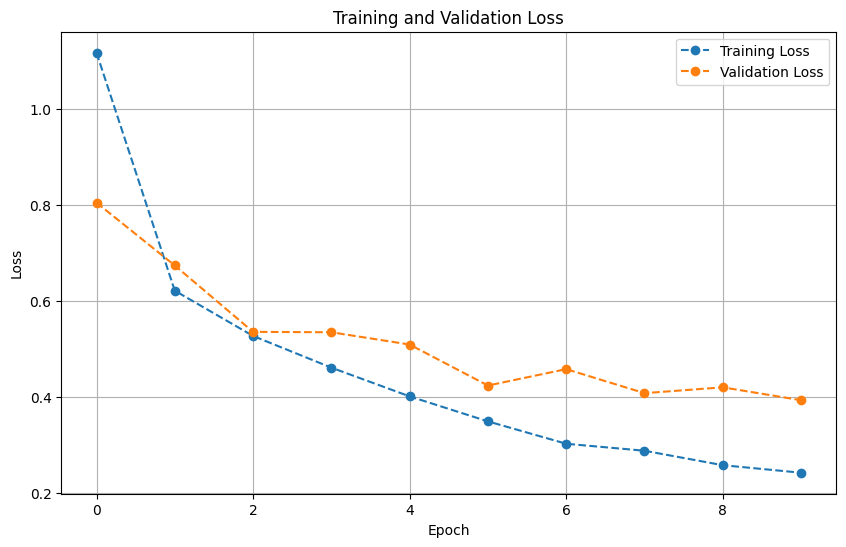

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_InceptionResNetV2.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_InceptionResNetV2.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


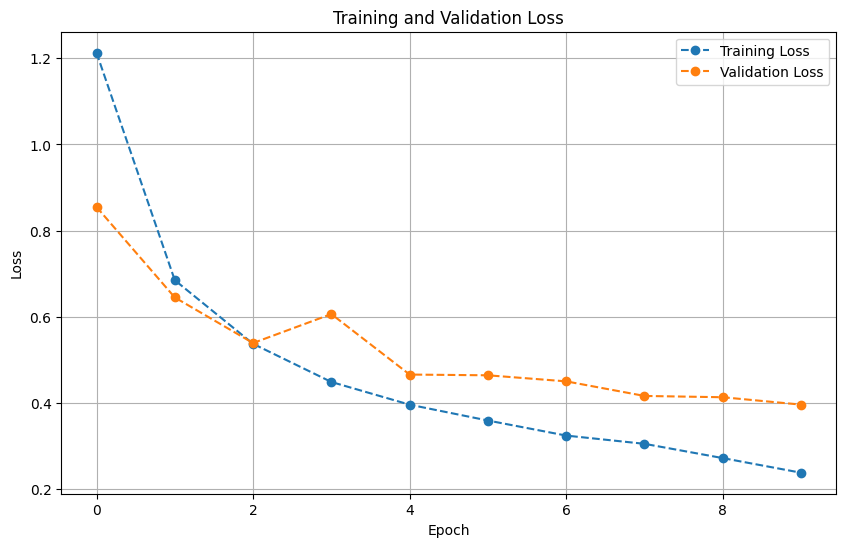

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_densenet.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Evaluate the model on the test data 
test_loss, test_acc = InceptionResNetV2.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

31/31 [==============================] - 23s 609ms/step - loss: 0.4119 - accuracy: 0.8637
Test Loss: 0.41190022230148315
Test Accuracy: 0.8637295365333557


In [12]:
# Evaluate the model on the test data 
test_loss, test_acc = densenet_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

31/31 [==============================] - 13s 304ms/step - loss: 0.3919 - accuracy: 0.8617
Test Loss: 0.391911119222641
Test Accuracy: 0.8616803288459778
